In [1]:
import pandas as pd
import numpy as np
import random as rnd
import scipy as sp

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn import metrics

from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
import statsmodels.api as sm

C:\Users\Ryan\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Import data from CSV files downloaded from drivendata.org.

In [2]:
train_df = pd.read_csv('data/dengue_features_train.csv')
train_labels = pd.read_csv('data/dengue_labels_train.csv')
test_df = pd.read_csv('data/dengue_features_test.csv')

Let's see what the features that we've been given are.

In [3]:
train_df.head()

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3   sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4   sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k        ...          \
0  0.177617                 12.42             297.572857        ...           
1  0.155486                 22.82             298.211429        ...           
2  0.170843                 34.54             298.781429        ...           
3  0.235886                 15.36             298.987143        ...           
4  0.247340                  7.52             299.518571        ...           

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            32.00                             73.365714   
1                            17.94                             77.368571   
2                            26.10                             82.052857   
3                            13.90                             80.337143   
4                            12.20                             80.460000   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         12.42                              14.012857   
1                         22.82                              15.372857   
2                         34.54                              16.848571   
3                         15.36                              16.672857   
4                          7.52                              17.210000   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0           2.628571           25.442857                 6.900000   
1           2.371429           26.714286                 6.371429   
2           2.300000           26.714286                 6.485714   
3           2.428571           27.471429                 6.771429   
4           3.014286           28.942857                 9.371429   

   station_max_temp_c  station_min_temp_c  station_precip_mm  
0                29.4                20.0               16.0  
1                31.7                22.2                8.6  
2                32.2                22.8               41.4  
3                33.3                23.3                4.0  
4                35.0                23.9                5.8  

[5 rows x 24 columns]

In [4]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

The weeks are wonky--some years have 53 weeks. I'll correct this by re-labelling the weeks column.

In [5]:
sj_df = train_df.loc[train_df["city"]=="sj",:].reset_index(drop=True)
iq_df = train_df.loc[train_df["city"]=="iq",:].reset_index(drop=True)
sj_labels = train_labels.loc[train_labels["city"]=="sj",:].reset_index(drop=True)
iq_labels = train_labels.loc[train_labels["city"]=="iq",:].reset_index(drop=True)
sj_df_test = test_df.loc[test_df["city"]=="sj",:].reset_index(drop=True)
iq_df_test = test_df.loc[test_df["city"]=="iq",:].reset_index(drop=True)

#---------------- sj train---------------#
nEntries = len(sj_df)
nYears = len(sj_df.groupby(['year'], as_index=False))
iWeek = 18
iYear = 0
idx = 0
correctedWeeks = np.zeros([nEntries,1])
while iYear < nYears:
    while iWeek < 53:
        if idx < nEntries:
            correctedWeeks[idx] = iWeek
        iWeek += 1
        idx += 1
    iWeek = 1
    iYear += 1
sj_df.loc[:,"weekofyear"] = correctedWeeks

#---------------- iq train---------------#
nEntries = len(iq_df)
nYears = len(iq_df.groupby(['year'], as_index=False))
iWeek = 26
iYear = 0
idx = 0
correctedWeeks = np.zeros([nEntries,1])
while iYear < nYears:
    while iWeek < 53:
        if idx < nEntries:
            correctedWeeks[idx] = iWeek
        iWeek += 1
        idx += 1
    iWeek = 1
    iYear += 1
iq_df.loc[:,"weekofyear"] = correctedWeeks

#---------------- sj test---------------#
nEntries = len(sj_df_test)
nYears = len(sj_df_test.groupby(['year'], as_index=False))
iWeek = 18
iYear = 0
idx = 0
correctedWeeks = np.zeros([nEntries,1])
while iYear < nYears:
    while iWeek < 53:
        if idx < nEntries:
            correctedWeeks[idx] = iWeek
        iWeek += 1
        idx += 1
    iWeek = 1
    iYear += 1
sj_df_test.loc[:,"weekofyear"] = correctedWeeks

#---------------- iq test---------------#
nEntries = len(iq_df_test)
nYears = len(iq_df_test.groupby(['year'], as_index=False))
iWeek = 26
iYear = 0
idx = 0
correctedWeeks = np.zeros([nEntries,1])
while iYear < nYears:
    while iWeek < 53:
        if idx < nEntries:
            correctedWeeks[idx] = iWeek
        iWeek += 1
        idx += 1
    iWeek = 1
    iYear += 1
iq_df_test.loc[:,"weekofyear"] = correctedWeeks

Some features are missing, particularly NDVI features. If they are correlated I will replace them with estimates from a linear regression model based on NDVI features that are present.

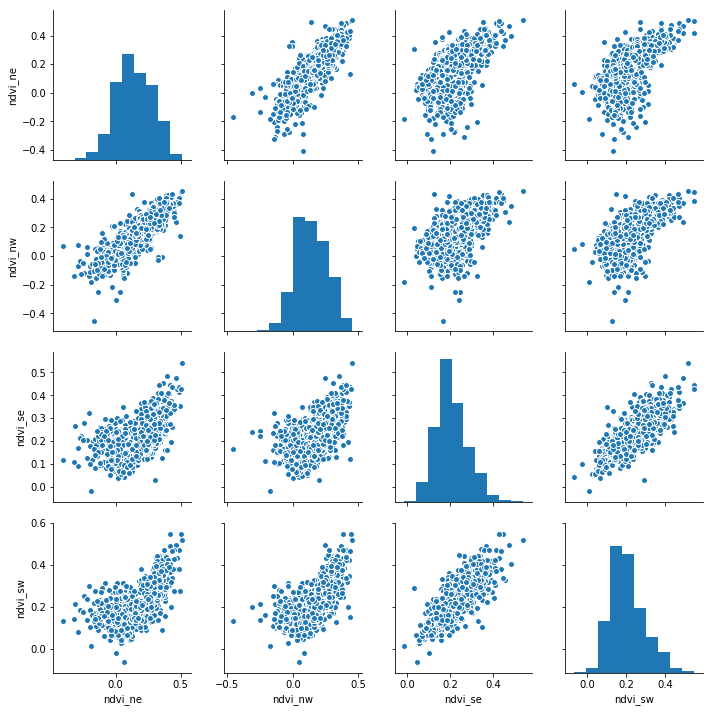

In [6]:
train_noNan = train_df[np.isfinite(train_df["ndvi_se"])]
train_noNan = train_noNan[np.isfinite(train_noNan["ndvi_sw"])]
train_noNan = train_noNan[np.isfinite(train_noNan["ndvi_ne"])]
train_noNan = train_noNan[np.isfinite(train_noNan["ndvi_nw"])]
sns.pairplot(train_noNan[["ndvi_ne", "ndvi_nw", "ndvi_se", "ndvi_sw"]])

YES!! The features are correlated with so I will fill in missing values in with linear extrapolations (separately for SJ and IQ)

In [7]:
def replaceEmpties(df):
    fix_df = df.copy()
    noNanIdx = np.isfinite(fix_df["ndvi_ne"]) & np.isfinite(fix_df["ndvi_nw"]) & np.isfinite(fix_df["ndvi_se"]) & np.isfinite(fix_df["ndvi_sw"])
    tmp_df = fix_df[noNanIdx]

    X = tmp_df[["ndvi_nw", "ndvi_sw", "ndvi_se"]]
    y = tmp_df["ndvi_ne"]
    lm = LinearRegression()
    model = lm.fit(X,y)
    
    nanIdx = np.isnan(fix_df["ndvi_ne"]) & np.isfinite(fix_df["ndvi_nw"]) & np.isfinite(fix_df["ndvi_se"]) & np.isfinite(fix_df["ndvi_sw"])
    if np.sum(nanIdx==True)>0:
        tmp = fix_df[nanIdx]
        tmp = tmp[["ndvi_nw", "ndvi_sw", "ndvi_se"]]
        predictions = lm.predict(tmp)
        fix_df.loc[nanIdx, "ndvi_ne"] = predictions

    # replace empty entries for ndvi_ne with values from linear model from nvdi,se,sw
    noNanIdx = np.isfinite(fix_df["ndvi_ne"]) & np.isfinite(fix_df["ndvi_se"]) & np.isfinite(fix_df["ndvi_sw"])
    tmp_df = fix_df[noNanIdx]

    X = tmp_df[["ndvi_sw", "ndvi_se"]]
    y = tmp_df["ndvi_ne"]
    lm = LinearRegression()
    model = lm.fit(X,y)

    nanIdx = np.isnan(fix_df["ndvi_ne"]) & np.isfinite(fix_df["ndvi_se"]) & np.isfinite(fix_df["ndvi_sw"])
    if np.sum(nanIdx==True)>0:
        tmp = fix_df[nanIdx]
        tmp = tmp[["ndvi_sw", "ndvi_se"]]
        predictions = lm.predict(tmp)
        fix_df.loc[nanIdx, "ndvi_ne"] = predictions

    # replace empty entries for ndvi_nw with values from linear model from nvdi,se,sw
    noNanIdx = np.isfinite(fix_df["ndvi_nw"]) & np.isfinite(fix_df["ndvi_se"]) & np.isfinite(fix_df["ndvi_sw"])
    tmp_df = fix_df[noNanIdx]

    X = tmp_df[["ndvi_sw", "ndvi_se"]]
    y = tmp_df["ndvi_nw"]
    lm = LinearRegression()
    model = lm.fit(X,y)

    nanIdx = np.isnan(fix_df["ndvi_nw"]) & np.isfinite(fix_df["ndvi_se"]) & np.isfinite(fix_df["ndvi_sw"])
    if np.sum(nanIdx==True)>0:
        tmp = fix_df[nanIdx]
        tmp = tmp[["ndvi_sw", "ndvi_se"]]
        predictions = lm.predict(tmp)
        fix_df.loc[nanIdx, "ndvi_nw"] = predictions

    # replace remaining empty values with weekly means
    weeklyMeans = fix_df.groupby(['weekofyear'], as_index=False).mean(numeric_only=1)
    weeklyStds = fix_df.groupby(['weekofyear'], as_index=False).std()
    headers = list(fix_df)
    nValues = len(headers)

    for iVal in range(4,nValues):
        hd = headers[iVal]
        hdNanIdx = np.isnan(fix_df[hd])
        weekList = fix_df.loc[hdNanIdx, "weekofyear"]
        tmp = np.zeros([len(weekList), 1])
        for iEntry in list(weekList.index):
            week = weekList[iEntry]
            if week > 0:
                tmp = weeklyMeans.loc[week-1, hd] + weeklyStds.loc[week-1, hd]*np.random.randn()
            else:
                tmp = weeklyMeans.loc[week, hd] + weeklyStds.loc[week, hd]*np.random.randn()
        fix_df.loc[hdNanIdx, hd] = tmp

    return fix_df

sj_df = replaceEmpties(sj_df)
iq_df = replaceEmpties(iq_df)
sj_df_test = replaceEmpties(sj_df_test)
iq_df_test = replaceEmpties(iq_df_test)

Let's inspect the relationship between the features and the number of dengue cases.

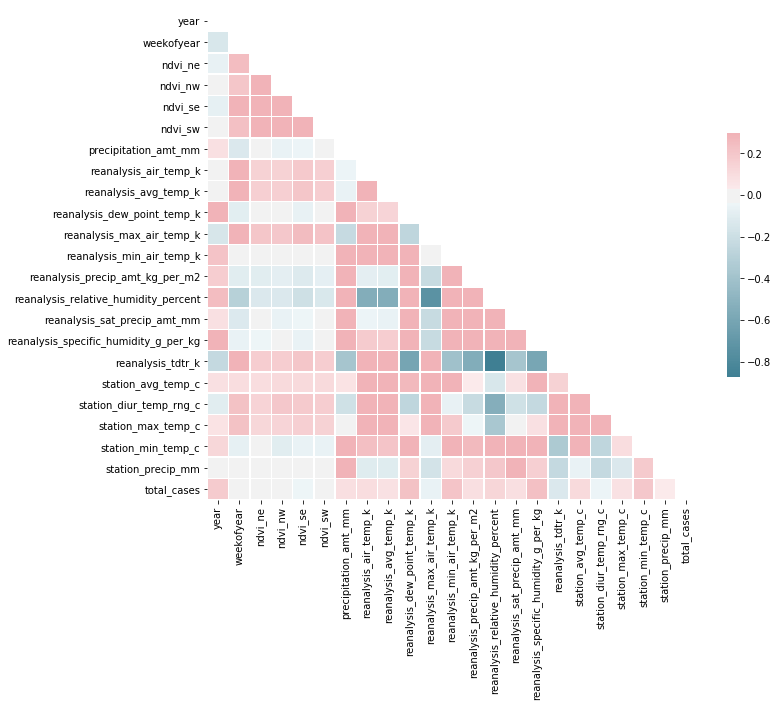

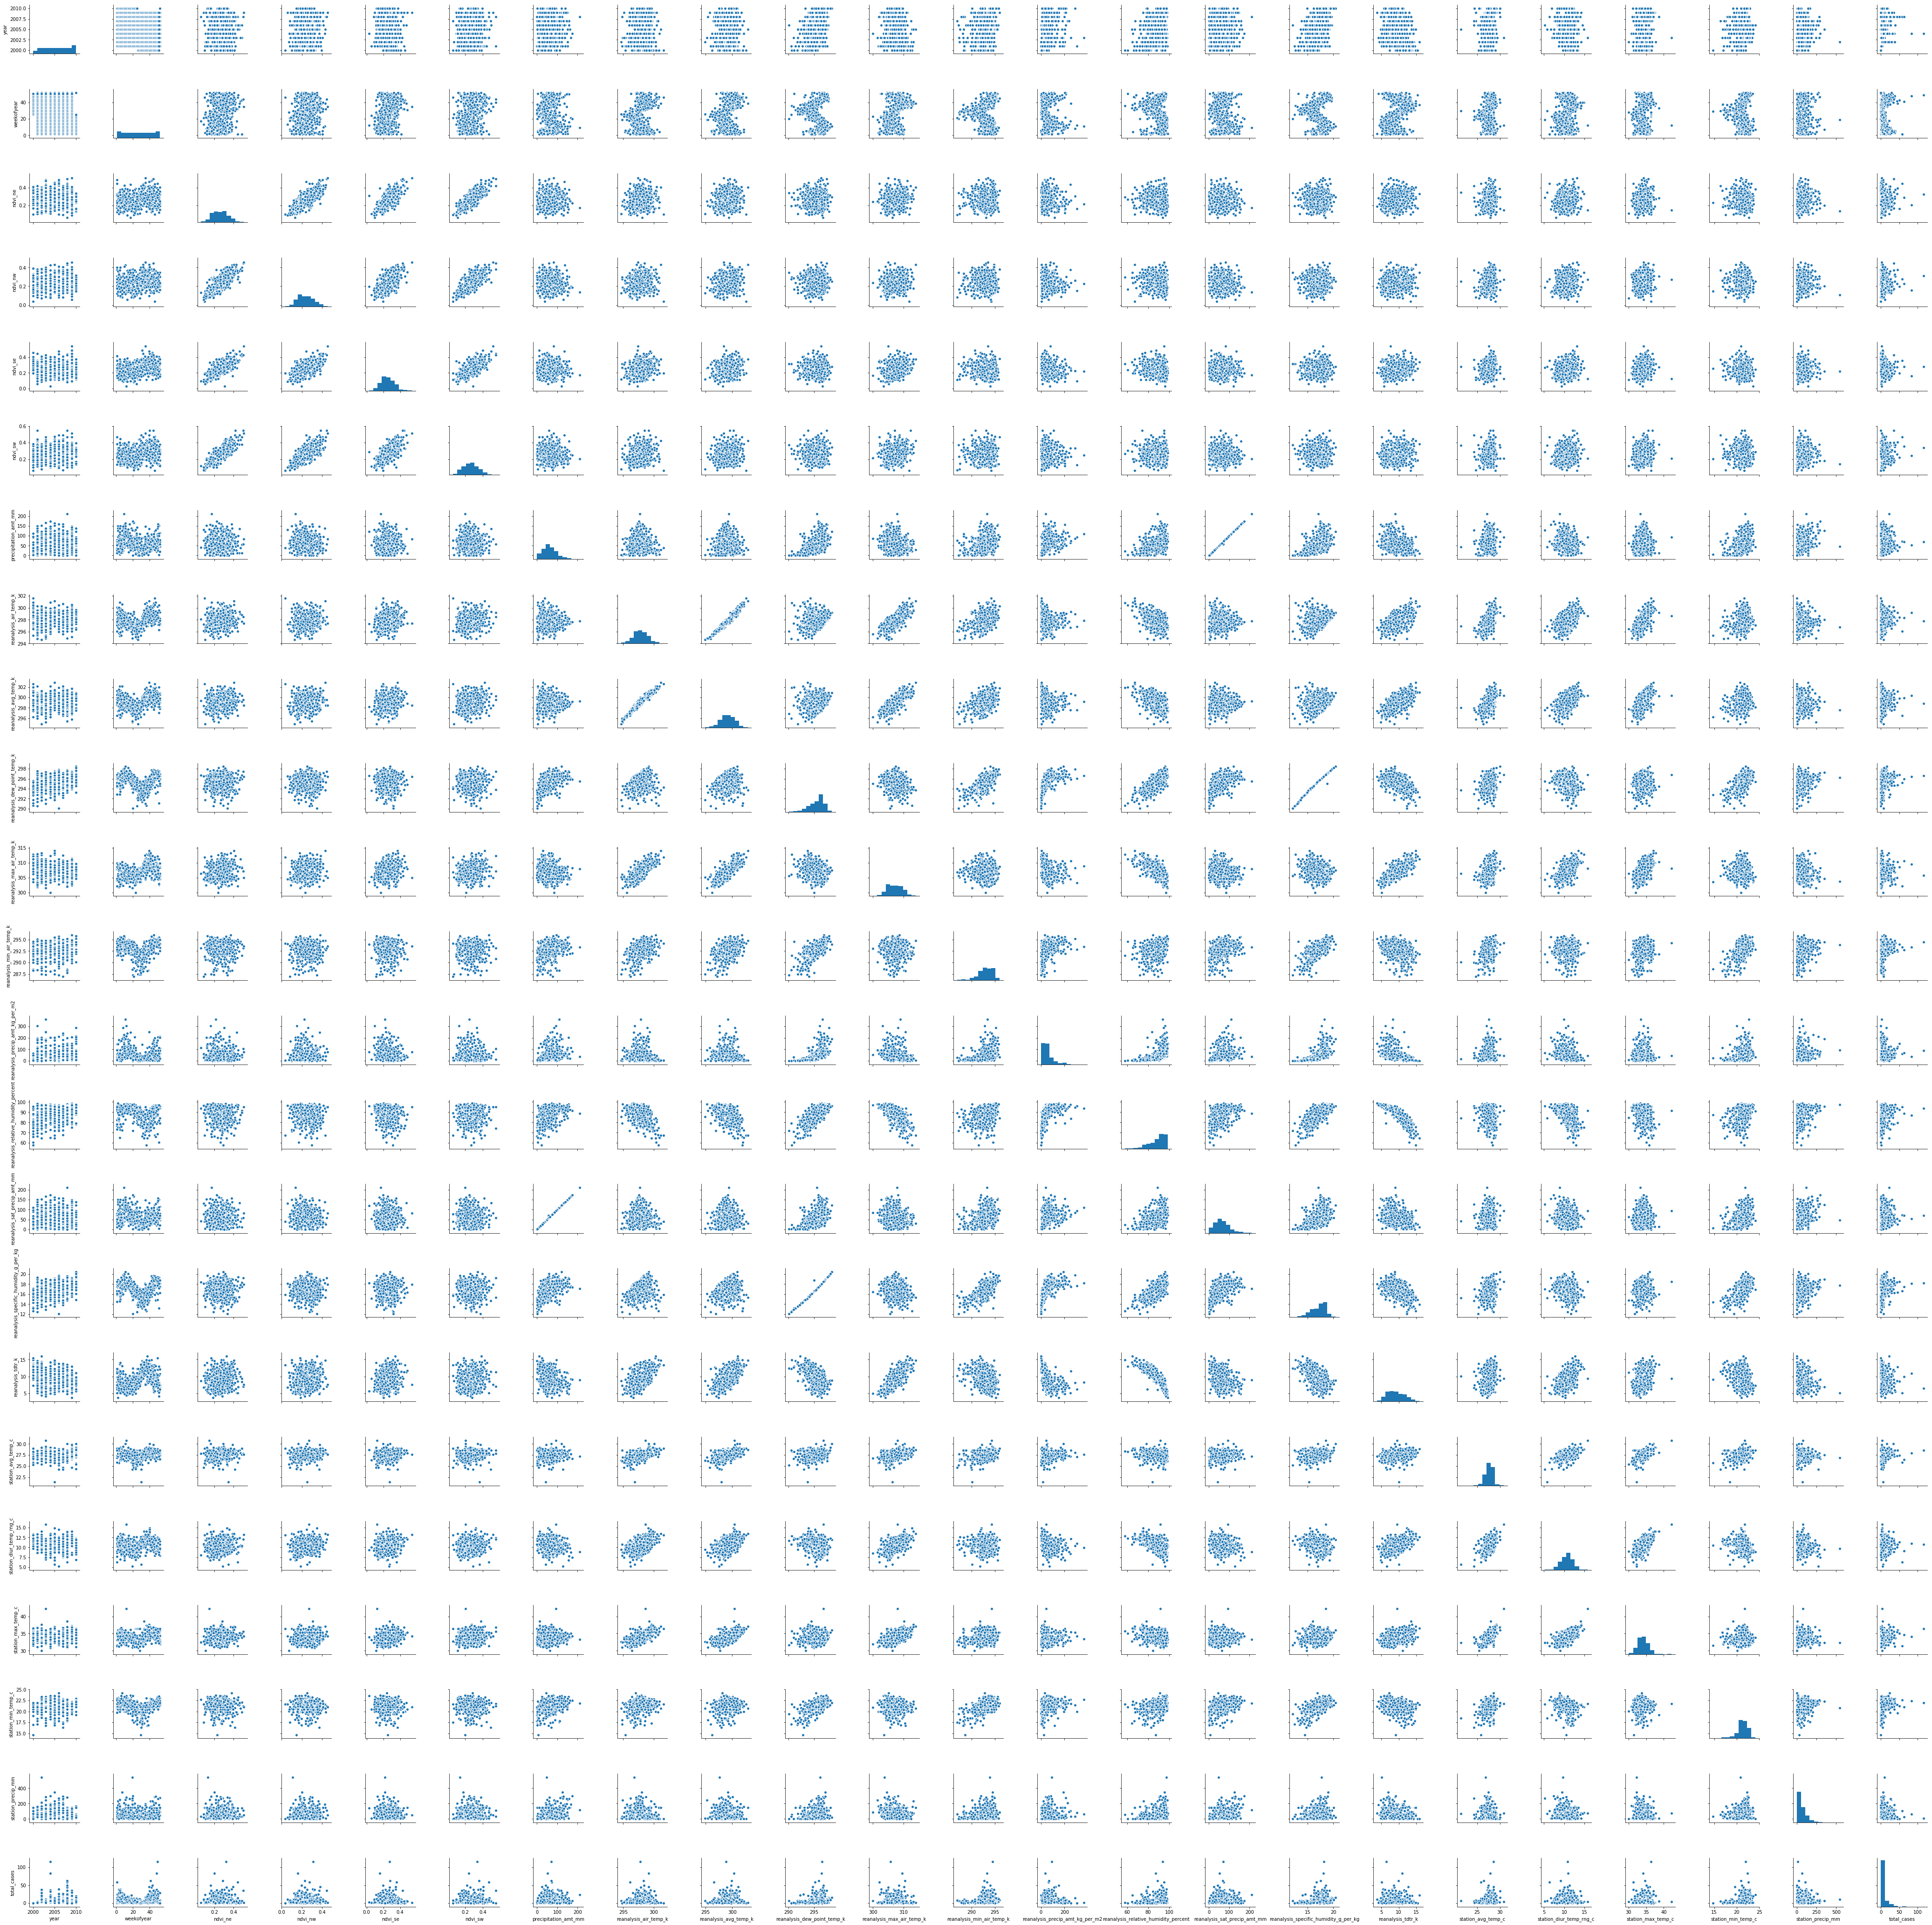

In [8]:
d = iq_df
withResults = pd.concat([d, iq_labels["total_cases"]], axis=1)
corr = withResults.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.pairplot(withResults)

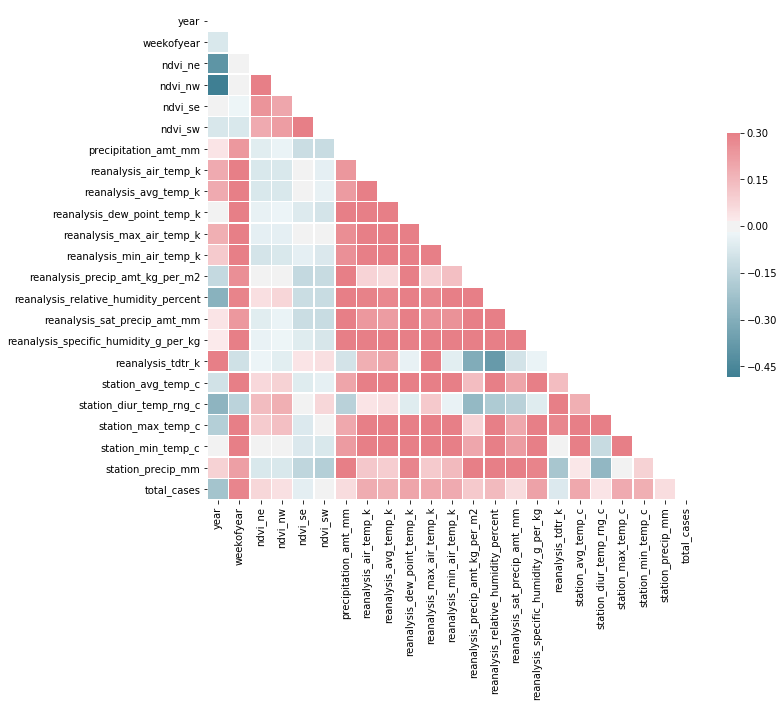

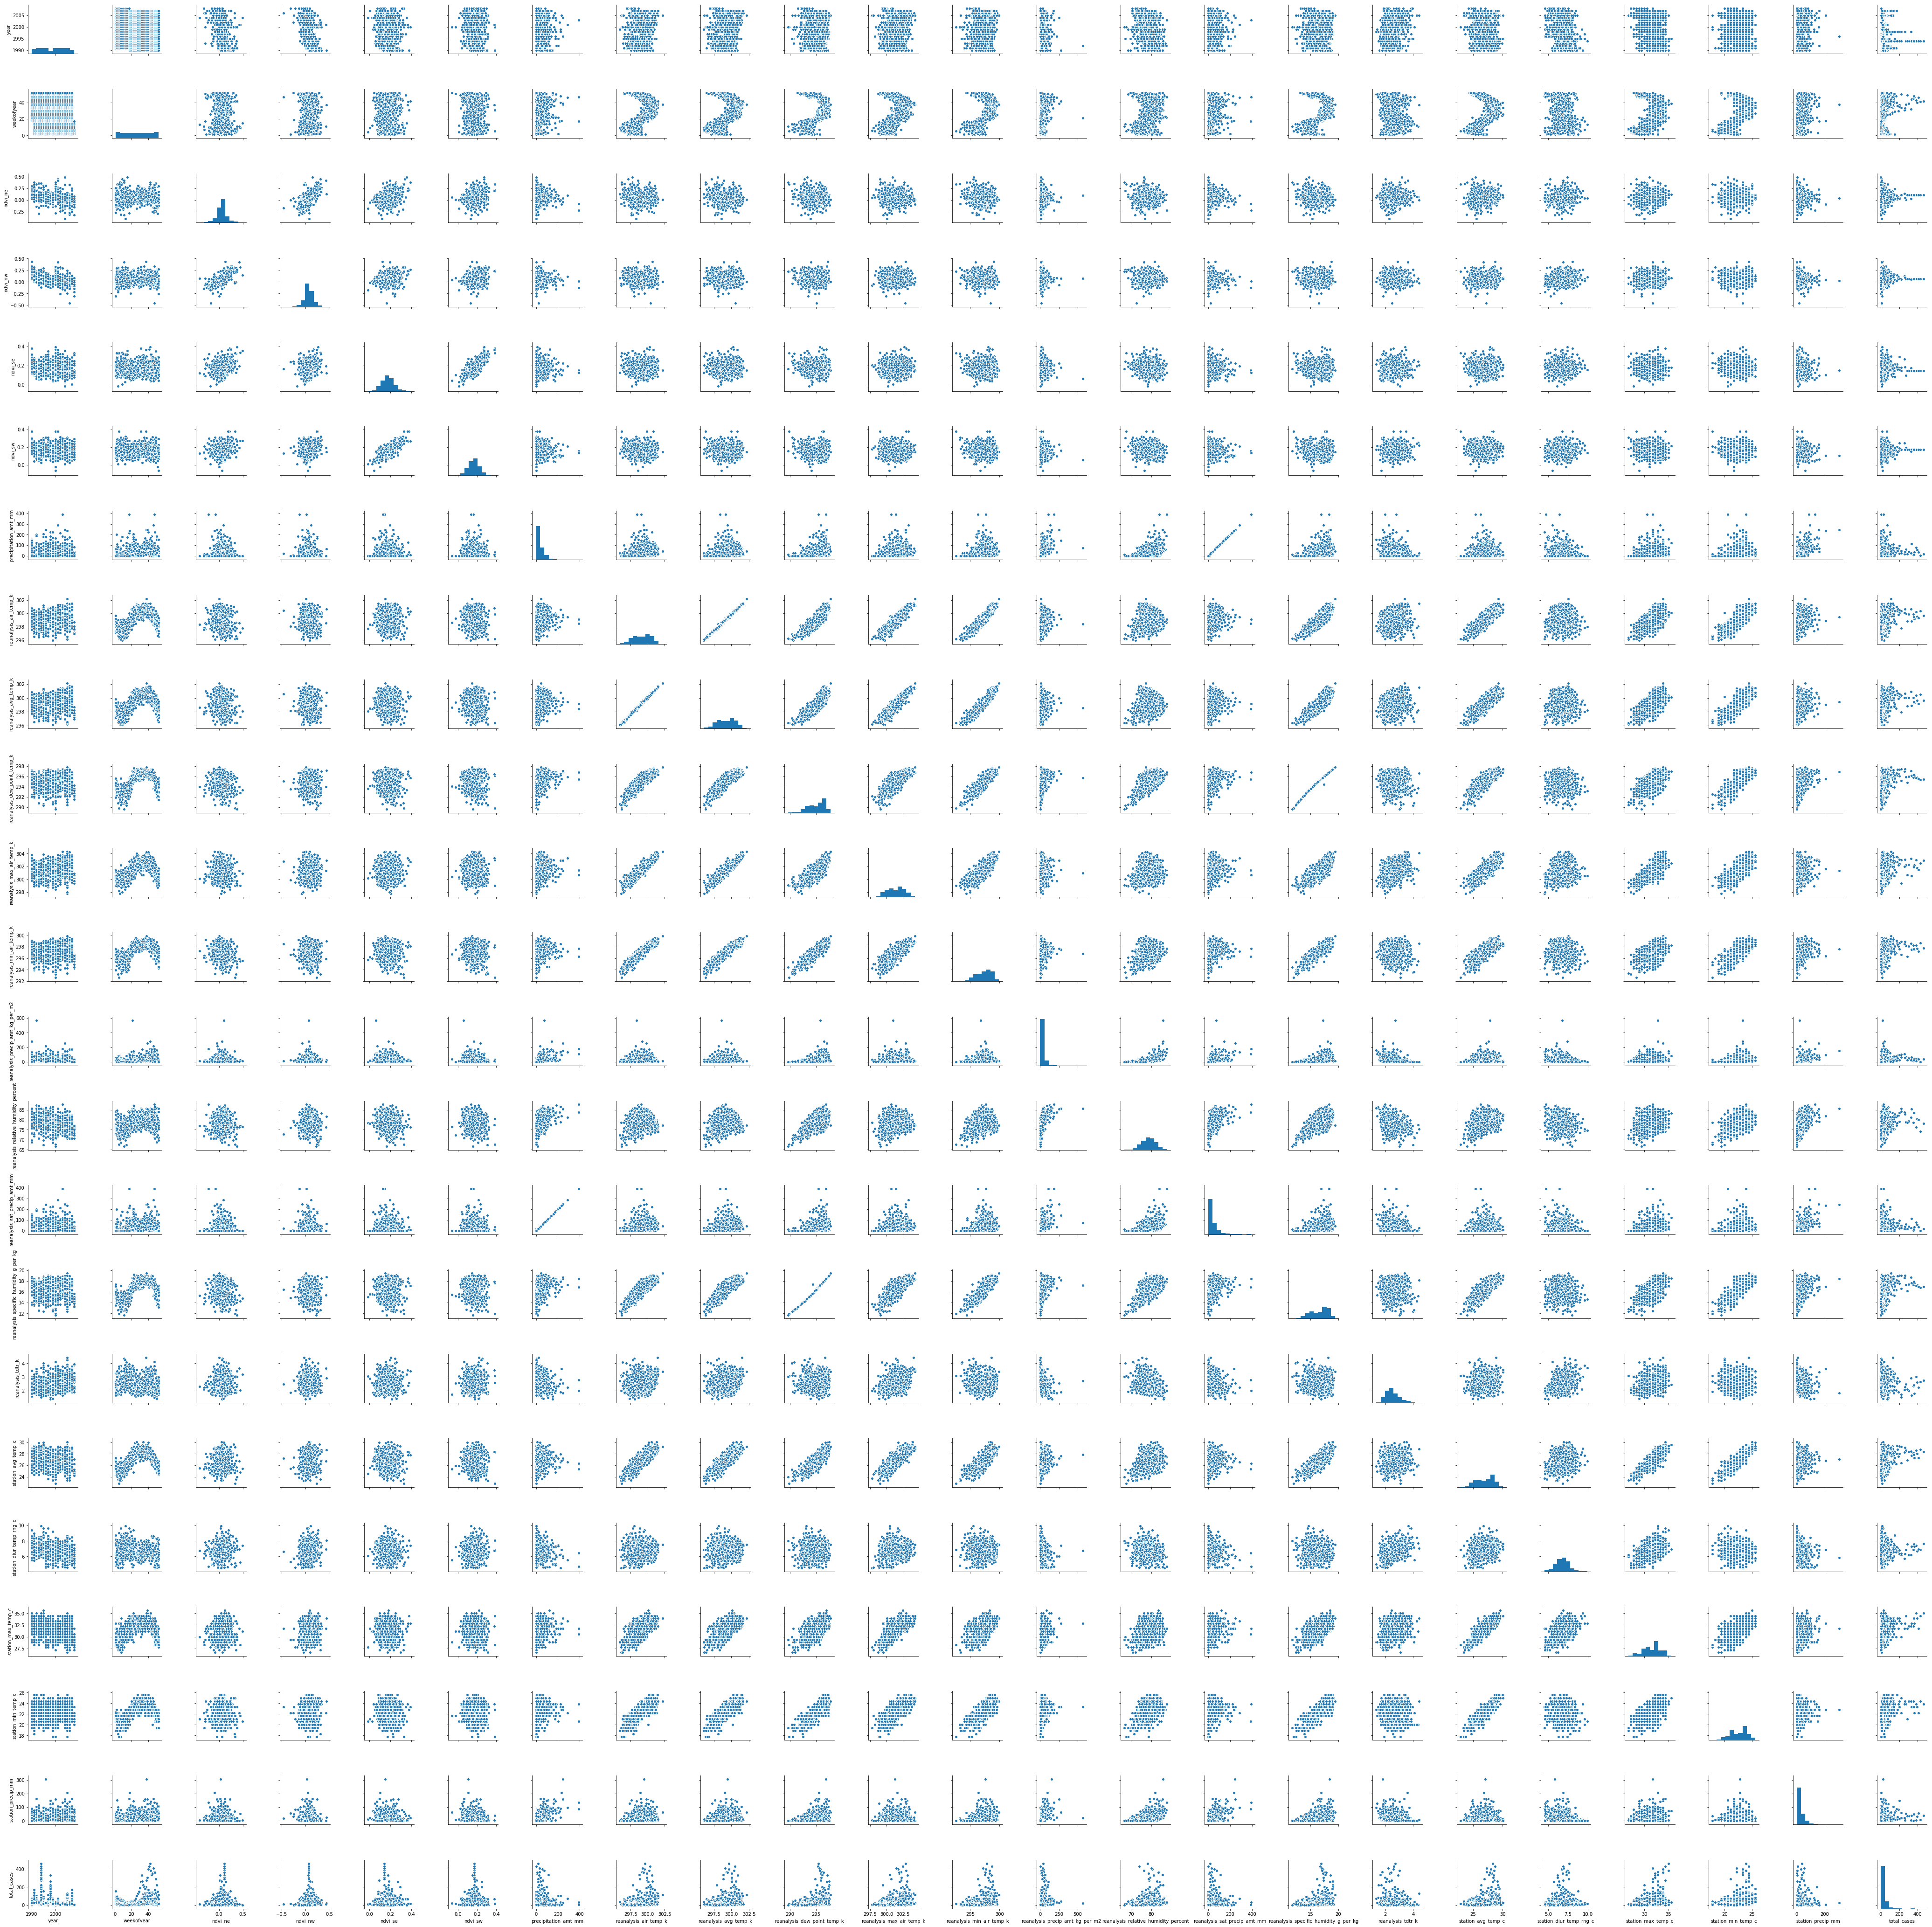

In [9]:
d = sj_df
withResults = pd.concat([d, sj_labels["total_cases"]], axis=1)
corr = withResults.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.pairplot(withResults)

There are some features that are correlated with the number of cases. But its possible that the relationships could be stronger with variable time delays. For example, the amount of rainfall a few months prior to month *X* may be a better predictor of the number of dengue cases in Month *X* than the rainfall in month *X*. To test this, I'll compute the correlations between each feature and the number of cases for a range of time lags. Then I'll save the time lag with the highest correlation for each feature for use later.

[ 0. 11. 15. 15. 24.  8.  8.  8.  7.  8.  2.  3. 24.  8.  2. 10. 24. 11.
 10. 22.]


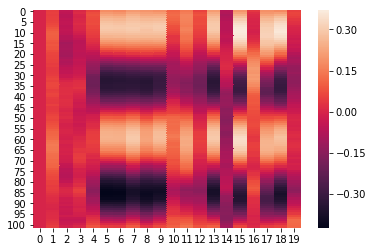

In [10]:
# SJ

nLags = 102
headers = list(sj_df)
hd = headers[4:]
corrWithLags = np.zeros([nLags,len(hd)])
nVals = len(sj_labels["total_cases"])
for iLag in range(0,nLags):
    for iHd in range(1, len(hd)):
        hd_tmp = hd[iHd]
        x = sj_df.loc[0:nVals-iLag-1, hd_tmp]
        y = sj_labels.loc[iLag:, "total_cases"]
        corrWithLags[iLag, iHd] = np.corrcoef(x,y)[0,1]
        
sns.heatmap(corrWithLags)

bestLagForFeature_sj = np.zeros((len(hd),))
for iHd in range(1, len(hd)):
    corrs = corrWithLags[:,iHd]
    idx = np.nonzero(abs(corrs[0:25]) == abs(corrs[0:25]).max())
    bestLagForFeature_sj[iHd] = idx[0]
    
print(bestLagForFeature_sj)

[ 0. 11. 14. 11. 23.  7. 10.  0. 14.  0. 21.  0. 23.  0. 17. 23. 10.  6.
 23.  3.]


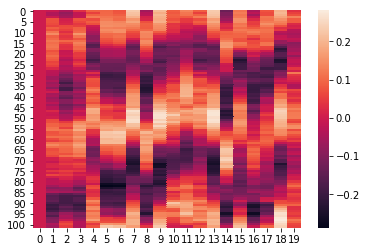

In [11]:
# IQ

corrWithLags = np.zeros([nLags,len(hd)])
nVals = len(iq_labels["total_cases"])
for iLag in range(0,nLags):
    for iHd in range(1, len(hd)):
        hd_tmp = hd[iHd]
        x = iq_df.loc[0:nVals-iLag-1, hd_tmp]
        y = iq_labels.loc[iLag:, "total_cases"]
        corrWithLags[iLag, iHd] = np.corrcoef(x,y)[0,1]
        
sns.heatmap(corrWithLags)

bestLagForFeature_iq = np.zeros((len(hd),))
for iHd in range(1, len(hd)):
    corrs = corrWithLags[:,iHd]
    idx = np.nonzero(abs(corrs[0:25]) == abs(corrs[0:25]).max())
    bestLagForFeature_iq[iHd] = idx[0]
    
print(bestLagForFeature_iq)

I'll use SVR to model the number of dengue cases. I will use the optimal lag for each feature in order to train separate models for the two cities. 

best gamma =  1e-06
best score =  17.17948717948718
22.563246425567968
best gamma =  1e-06
best score =  6.593908629441624
5.84054460431375


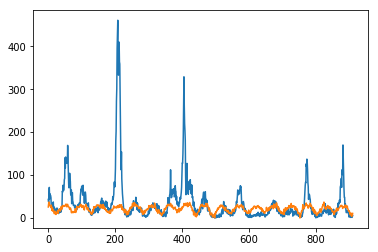

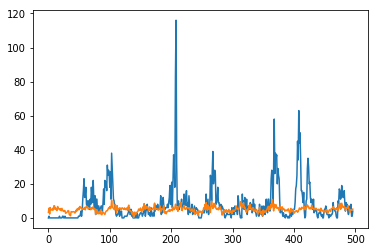

In [12]:
# SVR model

def get_best_model(train, test, hd):
    grid = 10 ** np.arange(-8, -1, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    #Find the best hyper parameter, alpha
    for g in grid:
        
        mdl = SVR(kernel='rbf', C=1e3, gamma=g)
        results = mdl.fit(train.loc[:,hd], train.loc[:,'total_cases'])
        predictions = results.predict(test.loc[:,hd]).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)
        
        if score < best_score:
            best_gamma = g
            best_score = score

    print('best gamma = ', best_gamma)
    print('best score = ', best_score)
            
    # Refit on entire dataset
    full_dataset = pd.concat([train, test], axis=0)
    mdl = SVR(kernel='rbf', C=1e3, gamma=best_gamma)
    fitted_model = mdl.fit(full_dataset.loc[:,hd], full_dataset.loc[:,'total_cases'])
    return fitted_model

# SJ
nTest = 600
headers = list(sj_df)
hd = headers[4:]
maxLag = max(bestLagForFeature_sj)
maxLagSJ = maxLag
lag = bestLagForFeature_sj[0]
x_train = sj_df.loc[maxLag-lag:nTest-1+maxLag-lag, hd[0]].reset_index(drop=True)
y_train = sj_labels.loc[maxLag:nTest-1+maxLag,"total_cases"].reset_index(drop=True)
x_test = sj_df.loc[nTest+maxLag-lag:len(sj_labels)-lag-1, hd[0]].reset_index(drop=True)
y_test = sj_labels.loc[nTest+maxLag:len(sj_labels)-1, "total_cases"].reset_index(drop=True)
for iFeat in range(1, len(hd)):
    lag = bestLagForFeature_sj[iFeat]
    x_train2 = sj_df.loc[maxLag-lag:nTest-1+maxLag-lag, hd[iFeat]].reset_index(drop=True)
    x_train = pd.concat([x_train, x_train2], axis=1)
    x_test2 = sj_df.loc[nTest+maxLag-lag:len(sj_labels)-lag-1, hd[iFeat]].reset_index(drop=True)
    x_test = pd.concat([x_test, x_test2], axis=1)
    
x_train['total_cases'] = y_train.astype(np.float64)
x_test['total_cases'] = y_test.astype(np.float64)

sj_best_model = get_best_model(x_train, x_test, hd)
combine = pd.concat([x_train, x_test], axis=0).reset_index(drop=True)
pred = sj_best_model.predict(combine.loc[:,hd])
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(combine.loc[:,'total_cases'])
ax1.plot(pred)
score = metrics.mean_absolute_error(combine.loc[:,'total_cases'],pred)
print(score)

# IQ
nTest = 300
headers = list(iq_df)
hd = headers[4:]
maxLag = max(bestLagForFeature_iq)
maxLagIQ = maxLag
lag = bestLagForFeature_iq[0]
x_train = iq_df.loc[maxLag-lag:nTest-1+maxLag-lag, hd[0]].reset_index(drop=True)
y_train = iq_labels.loc[maxLag:nTest-1+maxLag,"total_cases"].reset_index(drop=True)
x_test = iq_df.loc[nTest+maxLag-lag:len(iq_labels)-lag-1, hd[0]].reset_index(drop=True)
y_test = iq_labels.loc[nTest+maxLag:len(iq_labels)-1, "total_cases"].reset_index(drop=True)
for iFeat in range(1, len(hd)):
    lag = bestLagForFeature_iq[iFeat]
    x_train2 = iq_df.loc[maxLag-lag:nTest-1+maxLag-lag, hd[iFeat]].reset_index(drop=True)
    x_train = pd.concat([x_train, x_train2], axis=1)
    x_test2 = iq_df.loc[nTest+maxLag-lag:len(iq_labels)-lag-1, hd[iFeat]].reset_index(drop=True)
    x_test = pd.concat([x_test, x_test2], axis=1)

x_train.head()
x_train['total_cases'] = y_train.astype(np.float64)
x_test['total_cases'] = y_test.astype(np.float64)
    
iq_best_model = get_best_model(x_train, x_test, hd)
combine = pd.concat([x_train, x_test], axis=0).reset_index(drop=True)
pred = iq_best_model.predict(combine.loc[:,hd])
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(combine.loc[:,'total_cases'])
ax1.plot(pred)
score = metrics.mean_absolute_error(combine.loc[:,'total_cases'],pred)
print(score)


Making predictions on the test data with the fitted models

In [13]:
#SJ
sj_combined = pd.concat((sj_df, sj_df_test), axis=0).reset_index(drop=True)
sj_combined = sj_combined.loc[len(sj_combined)-len(sj_df_test)-maxLagSJ:len(sj_combined)-1,hd].reset_index(drop=True)
maxLag = maxLagSJ
lag = bestLagForFeature_sj[0]
x_test = sj_combined.loc[maxLag-lag:len(sj_combined)-1-lag, hd[0]].reset_index(drop=True)
for iFeat in range(1, len(hd)):
    lag = bestLagForFeature_sj[iFeat]
    x_test2 = sj_combined.loc[maxLag-lag:len(sj_combined)-1-lag, hd[iFeat]].reset_index(drop=True)
    x_test = pd.concat([x_test, x_test2], axis=1)
pred_sj = sj_best_model.predict(x_test)

# IQ
iq_combined = pd.concat((iq_df, iq_df_test), axis=0).reset_index(drop=True)
iq_combined = iq_combined.loc[len(iq_combined)-len(iq_df_test)-maxLagIQ:len(iq_combined)-1,hd].reset_index(drop=True)
maxLag = maxLagIQ
lag = bestLagForFeature_iq[0]
x_test = iq_combined.loc[maxLag-lag:len(iq_combined)-1-lag, hd[0]].reset_index(drop=True)
for iFeat in range(1, len(hd)):
    lag = bestLagForFeature_iq[iFeat]
    x_test2 = iq_combined.loc[maxLag-lag:len(iq_combined)-1-lag, hd[iFeat]].reset_index(drop=True)
    x_test = pd.concat([x_test, x_test2], axis=1)
x_test = x_test.fillna(value=0) #theres one lingering NaN
pred_iq = iq_best_model.predict(x_test)

combined = np.concatenate((pred_sj, pred_iq), axis=0)
combined = combined.astype(int)

#combined.to_csv('data/output_180604.csv')
np.savetxt("data/output_180604.csv", combined, delimiter=",")